<img src="https://user-images.strikinglycdn.com/res/hrscywv4p/image/upload/c_limit,fl_lossy,h_300,w_300,f_auto,q_auto/1266110/Logo_wzxi0f.png" style="float: left; margin: 20px; height: 55px">

**In my experience, it is rarer to find a really happy person in a circle of millionaires than among vagabonds - Thor Heyerdahl**

# Chapter 9 - Hypothesis Testing

## Classical hypothesis testing

Exploring the data from the NSFG, we saw several “apparent effects,” including differences between first babies and others. So far we have taken these effects at face value; in this chapter, we put them to the test.

The fundamental question we want to address is whether the effects we see in a sample are likely to appear in the larger population. For example, in the NSFG sample we see a difference in mean pregnancy length for first babies
and others. We would like to know if that effect reflects a real difference for women in the U.S., or if it might appear in the sample by chance.

There are several ways we could formulate this question, including Fisher null hypothesis testing, Neyman-Pearson decision theory, and Bayesian inference. What I present here is a subset of all three that makes up most of what people use in practice, which I will call **classical hypothesis testing**.

The goal of classical hypothesis testing is to answer the question, “Given a sample and an apparent effect, what is the probability of seeing such an effect by chance?” Here’s how we answer that question:

1. The first step is to quantify the size of the apparent effect by choosing a **test statistic**. In the NSFG example, the apparent effect is a difference in pregnancy length between first babies and others, so a natural choice for the test statistic is the difference in means between the two groups.

2. The second step is to define a **null hypothesis**, which is a model of the system based on the assumption that the apparent effect is not real. In the NSFG example the null hypothesis is that there is no difference between first babies and others; that is, that pregnancy lengths for both groups have the same distribution.

3. The third step is to compute a **p-value**, which is the probability of seeing the apparent effect if the null hypothesis is true. In the NSFG example, we would compute the actual difference in means, then compute the probability of seeing a difference as big, or bigger, under the null hypothesis.

4. The last step is to interpret the result. If the p-value is low, the effect is said to be **statistically significant**, which means that it is unlikely to have occurred by chance. In that case we infer that the effect is more likely to appear in the larger population.

**Create a cram card asking the hypothesis testing process**

The logic of this process is similar to a proof by contradiction. To prove a mathematical statement, A, you assume temporarily that A is false. If that assumption leads to a contradiction, you conclude that A must actually be
true.

Similarly, to test a hypothesis like, “This effect is real,” we assume, temporarily, that it is not. That’s the null hypothesis. Based on that assumption, we compute the probability of the apparent effect. That’s the p-value. If the p-value is low, we conclude that the null hypothesis is unlikely to be true.

## Hypothesis test

`thinkstats2` provides `HypothesisTest`, a class that represents the structure of a classical hypothesis test. Search it an copy it here and explain each of the parts of this parent class (read the following [blog](https://www.digitalocean.com/community/tutorials/understanding-class-inheritance-in-python-3)):

In [1]:
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None
        self.test_cdf = None

    def PValue(self, iters=1000):
        """Computes the distribution of the test statistic and p-value.

        iters: number of iterations

        returns: float p-value
        """
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]
        self.test_cdf = Cdf(self.test_stats)

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def MaxTestStat(self):
        """Returns the largest test statistic seen during simulations.
        """
        return max(self.test_stats)

    def PlotCdf(self, label=None):
        """Draws a Cdf with vertical lines at the observed test stat.
        """
        def VertLine(x):
            """Draws a vertical line at x."""
            thinkplot.Plot([x, x], [0, 1], color='0.8')

        VertLine(self.actual)
        thinkplot.Cdf(self.test_cdf, label=label)

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        pass

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()

HypothesisTest is an abstract parent class that provides complete definitions for some methods and place-keepers for others. Child classes based on HypothesisTest inherit `__init__` and PValue and provide TestStatistic, RunModel, and optionally MakeModel.

`__init__` takes the data in whatever form is appropriate. It calls MakeModel, which builds a representation of the null hypothesis, then passes the data to TestStatistic, which computes the size of the effect in the sample.

PValue computes the probability of the apparent effect under the null hypothesis. It takes as a parameter iters, which is the number of simulations to run. The first line generates simulated data, computes test statistics, and stores them in test_stats. The result is the fraction of elements in test_stats that exceed or equal the observed test statistic, self.actual.

An example. Suppose we toss a coin 250 times and see 140 heads and 110 tails. Based on this result, we might suspect that the coin is biased; that is, more likely to land heads. To test this hypothesis, we compute the probability of seeing such a difference if the coin is actually fair:

In [2]:
from Resources.Think_Stats.Thinkstats2 import thinkstats2
import random

In [3]:
class CoinTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat
    
    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

The parameter, data, is a pair of integers: the number of heads and tails. The test statistic is the absolute difference between them, so self.actual
is 30.

RunModel simulates coin tosses assuming that the coin is actually fair. It generates a sample of 250 tosses, uses Hist to count the number of heads and tails, and returns a pair of integers.

Now all we have to do is instantiate CoinTest and call PValue:

In [4]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()

In [5]:
pvalue

0.065

The result is about 0.07, which means that if the coin is fair, we expect to see a difference as big as 30 about 7% of the time.

How should we interpret this result? By convention, 5% is the threshold of statistical significance. If the p-value is less than 5%, the effect is considered significant; otherwise it is not.

But the choice of 5% is arbitrary, and (as we will see later) the p-value depends on the choice of the test statistics and the model of the null hypothesis. So p-values should not be considered precise measurements.

I recommend interpreting p-values according to their order of magnitude: if the p-value is less than 1%, the effect is unlikely to be due to chance; if it is greater than 10%, the effect can plausibly be explained by chance. P-values between 1% and 10% should be considered borderline. So in this example I conclude that the data do not provide strong evidence that the coin is biased or not.

Create a new experiment. Suppose we roll a dice 400 times and see 40 fives. Based on this result, we might suspect that the dice is biased; that is, more less likely to get a 5. To test this hypothesis, compute the probability of seeing such a difference if the dice is actually fair.

Create a test to calculate it and call PValue:

In [6]:
class DiceTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        other, fives = data
        test_stat = fives
        return test_stat
    
    def RunModel(self):
        other, fives = self.data
        n = other + fives
        sample = [random.choice('xxxxx5') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['x'], hist['5']
        return data

In [7]:
dt = DiceTest((360, 40))
pvalue = dt.PValue()

In [8]:
pvalue

1.0

## Testing a difference in means

One of the most common effects to test is a difference in mean between two groups. In the NSFG data, we saw that the mean pregnancy length for first babies is slightly longer, and the mean birth weight is slightly smaller. Now we will see if those effects are statistically significant.

For these examples, the null hypothesis is that the distributions for the two groups are the same. One way to model the null hypothesis is by **permutation**; that is, we can take values for first babies and others and shuffle them, treating the two groups as one big group:

In [9]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
        
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

data is a pair of sequences, one for each group. The test statistic is the absolute difference in the means.

MakeModel records the sizes of the groups, n and m, and combines the groups into one NumPy array, self.pool.

RunModel simulates the null hypothesis by shuffling the pooled values and splitting them into two groups with sizes n and m. As always, the return value from RunModel has the same format as the observed data.

To test the difference in pregnancy length, we run:

In [10]:
from Resources.Think_Stats.Thinkstats2 import first
import numpy as np

In [11]:
live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values
ht = DiffMeansPermute(data)
pvalue = ht.PValue()

In [12]:
ht.actual

0.07803726677754952

In [13]:
pvalue

0.159

MakeFrames reads the NSFG data and returns DataFrames representing all live births, first babies, and others. We extract pregnancy lengths as NumPy arrays, pass them as data to DiffMeansPermute, and compute the p-value. The result is about 0.17, which means that we expect to see a difference as big as the observed effect about 17% of the time. So this effect is not statistically significant.

HypothesisTest provides PlotCdf, which plots the distribution of the test statistic and a gray line indicating the observed effect size:

In [14]:
from Resources.Think_Stats.Thinkstats2 import thinkplot

No handles with labels found to put in legend.


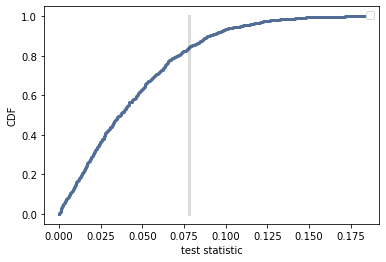

<Figure size 576x432 with 0 Axes>

In [15]:
ht.PlotCdf()
thinkplot.Show(xlabel='test statistic',
ylabel='CDF')

Repeat the analysis comparing weight of babies between first babies and others, interpret the results:

In [16]:
firsts_wtg = firsts.birthwgt_lb.dropna()
others_wtg = others.birthwgt_lb.dropna()

In [17]:
data = firsts_wtg, others_wtg
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
print(ht.actual)
print(pvalue)

0.1528567934022922
0.0


No handles with labels found to put in legend.


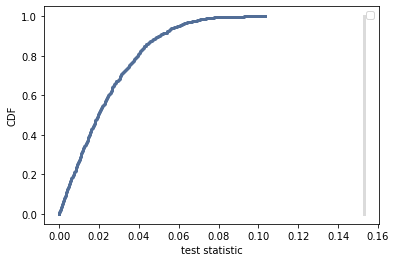

<Figure size 576x432 with 0 Axes>

In [18]:
ht.PlotCdf()
thinkplot.Show(xlabel='test statistic',
ylabel='CDF')

If we run the same analysis with birth weight, the computed p-value is 0; after 1000 attempts, the simulation never yields an effect as big as the observed difference, 0.12 lbs. So we would report p < 0.001, and conclude that the difference in birth weight is statistically significant.

## Other test statistics

Choosing the best test statistic depends on what question you are trying to address. For example, if the relevant question is whether pregnancy lengths are different for first babies, then it makes sense to test the absolute difference in means, as we did in the previous section.

If we had some reason to think that first babies are likely to be late, then we would not take the absolute value of the difference; instead we would use this test statistic:

In [19]:
class DiffMeansOneSided(DiffMeansPermute):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

DiffMeansOneSided inherits MakeModel and RunModel from DiffMeansPermute; the only difference is that TestStatistic does not take the absolute value of the difference. This kind of test is called **one-sided** because it only counts one side of the distribution of differences. The previous test, using both sides, is **two-sided**.

In [20]:
data = firsts.prglngth.values, others.prglngth.values
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()

In [21]:
pvalue

0.091

In [22]:
ht.actual

0.07803726677754952

For this version of the test, the p-value is 0.09. In general the p-value for a one-sided test is about half the p-value for a two-sided test, depending on the shape of the distribution.

The one-sided hypothesis, that first babies are born late, is more specific than the two-sided hypothesis, so the p-value is smaller. But even for the stronger hypothesis, the difference is not statistically significant.

We can use the same framework to test for a difference in standard deviation. In Section 3.3, we saw some evidence that first babies are more likely to be early or late, and less likely to be on time. So we might hypothesize that the standard deviation is higher. Here’s how we can test that:

In [23]:
class DiffStdPermute(DiffMeansPermute):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [24]:
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue

0.081

This is a one-sided test because the hypothesis is that the standard deviation for first babies is higher, not just different. The p-value is 0.09, which is not statistically significant.

## Testing a correlation

This framework can also test correlations. For example, in the NSFG data set, the correlation between birth weight and mother’s age is about 0.07. It seems like older mothers have heavier babies. But could this effect be due to
chance?

For the test statistic, I use Pearson’s correlation, but Spearman’s would work as well. If we had reason to expect positive correlation, we would do a one-sided test. But since we have no such reason, I’ll do a two-sided test using the absolute value of correlation.

The null hypothesis is that there is no correlation between mother’s age and birth weight. By shuffling the observed values, we can simulate a world where the distributions of age and birth weight are the same, but where the variables are unrelated:

In [25]:
class CorrelationPermute(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

data is a pair of sequences. TestStatistic computes the absolute value of Pearson’s correlation. RunModel shuffles the xs and returns simulated data.

Here’s the code that reads the data and runs the test:

In [26]:
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = live.agepreg.values, live.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()

In [27]:
pvalue

0.0

In [28]:
ht.actual, ht.MaxTestStat()

(0.06883397035410908, 0.0360904369594931)

No handles with labels found to put in legend.


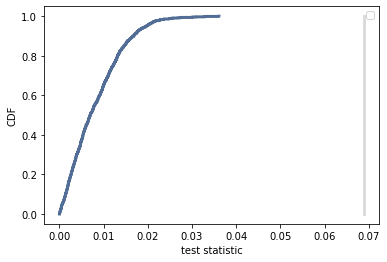

<Figure size 576x432 with 0 Axes>

In [29]:
ht.PlotCdf()
thinkplot.Show(xlabel='test statistic',
ylabel='CDF')

I use dropna with the subset argument to drop rows that are missing either of the variables we need.

The actual correlation is 0.07. The computed p-value is 0; after 1000 iterations the largest simulated correlation is 0.04. So although the observed correlation is small, it is statistically significant.

This example is a reminder that “statistically significant” does not always mean that an effect is important, or significant in practice. It only means that it is unlikely to have occurred by chance.

Calculate the correlation between weight and height and its p-value:

In [30]:
print(thinkstats2.Corr(live.birthwgt_lb, live.pregordr))
data = live.birthwgt_lb.values, live.pregordr.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
print(pvalue)

0.0031950080287916596
0.764


## Testing proportions

Suppose you run a casino and you suspect that a customer is using a crooked die; that is, one that has been modified to make one of the faces more likely than the others. You apprehend the alleged cheater and confiscate the dice but now you have to prove that it is crooked. You roll the die 60 times and get the following results:


![alt text](Resources/Think_Stats/notebookpics/dice.png "Title")

On average you expect each value to appear 10 times. In this dataset, the value 3 appears more often than expected, and the value 4 appears less often. But are these differences statistically significant?

To test this hypothesis, we can compute the expected frequency for each value, the difference between the expected and observed frequencies, and the total absolute difference. In this example, we expect each side to come up 10 times out of 60; the deviations from this expectation are -2, -1, 9, -5, -2, and 1; so the total absolute difference is 20. How often would we see such a difference by chance?

In [31]:
l = [5, 4,6, 7, 7]
m = 5
sum([np.abs(m - x) for x in l])

6

In [32]:
class TestingProportions(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        ones, twos, threes, fours, fives, sixs = data
        l = [ones, twos, threes, fours, fives, sixs]
        m = (ones + twos + threes + fours + fives + sixs) / 6
        test_stat = sum([np.abs(m - x) for x in l])
        return test_stat
    
    def RunModel(self):
        ones, twos, threes, fours, fives, sixs = self.data
        n = ones + twos + threes + fours + fives + sixs
        sample = [random.choice('123456') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['1'], hist['2'], hist['3'], hist['4'], hist['5'], hist['6']
        return data

In [33]:
dt = TestingProportions([8, 9, 19, 5, 8, 11])
pvalue = dt.PValue()

In [34]:
pvalue

0.121

## Chi-squared test

In the previous section we used total deviation as the test statistic. But for testing proportions it is more common to use the **chi-squared statistic**:

![alt text](Resources/Think_Stats/notebookpics/chi_squared.png "Title")

Where O i are the observed frequencies and E i are the expected frequencies. code it in python:

In [35]:
class DiceChiTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        ones, twos, threes, fours, fives, sixs = data
        l = [ones, twos, threes, fours, fives, sixs]
        m = (ones + twos + threes + fours + fives + sixs) / 6
        test_stat = sum([(x - m)**2/m for x in l])
        return test_stat
    
    def RunModel(self):
        ones, twos, threes, fours, fives, sixs = self.data
        n = ones + twos + threes + fours + fives + sixs
        sample = [random.choice('123456') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['1'], hist['2'], hist['3'], hist['4'], hist['5'], hist['6']
        return data

Squaring the deviations (rather than taking absolute values) gives more weight to large deviations. Dividing through by expected standardizes the deviations, although in this case it has no effect because the expected frequencies are all equal.

Repeat the previous example with a Chi-squared test.

In [36]:
dt = DiceChiTest([8, 9, 19, 5, 8, 11])
pvalue = dt.PValue()

In [37]:
pvalue

0.041

## First babies again

Earlier in this chapter we looked at pregnancy lengths for first babies and others, and concluded that the apparent differences in mean and standard deviation are not statistically significant. But in Section 3.3, we saw several
apparent differences in the distribution of pregnancy length, especially in the range from 35 to 43 weeks. To see whether those differences are statistically significant, we can use a test based on a chi-squared statistic.

The code combines elements from previous examples:

In [38]:
class PregLengthTest(thinkstats2.HypothesisTest):
    
    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))
        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))
        
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

The data are represented as two lists of pregnancy lengths. The null hypothesis is that both samples are drawn from the same distribution. MakeModel models that distribution by pooling the two samples using hstack. Then RunModel generates simulated data by shuffling the pooled sample and splitting it into two parts.

MakeModel also defines values, which is the range of weeks we’ll use, and expected_probs, which is the probability of each value in the pooled distribution.

Here’s the code that computes the test statistic:

In [39]:
class PregLengthTest(thinkstats2.HypothesisTest):
    
    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))
        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))
        
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat
    
    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

TestStatistic computes the chi-squared statistic for first babies and others, and adds them.

ChiSquared takes a sequence of pregnancy lengths, computes its histogram, and computes observed, which is a list of frequencies corresponding to self.values. To compute the list of expected frequencies, it multiplies the precomputed probabilities, expected_probs, by the sample size. It returns  the chi-squared statistic, stat.

In [40]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
pvalue = ht.PValue()
pvalue

0.0

In [41]:
ht.actual, ht.MaxTestStat()

(101.50141482893264, 25.861988977615177)

No handles with labels found to put in legend.


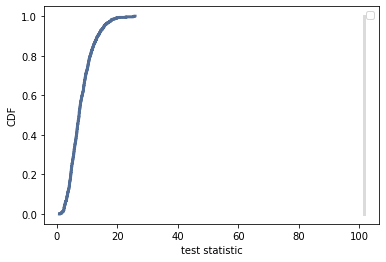

<Figure size 576x432 with 0 Axes>

In [42]:
ht.PlotCdf()
thinkplot.Show(xlabel='test statistic',
ylabel='CDF')

For the NSFG data the total chi-squared statistic is 102, which doesn’t mean much by itself. But after 1000 iterations, the largest test statistic generated under the null hypothesis is 32. We conclude that the observed chi-squared statistic is unlikely under the null hypothesis, so the apparent effect is statistically significant.

This example demonstrates a limitation of chi-squared tests: they indicate that there is a difference between the two groups, but they don’t say anything specific about what the difference is.

Repeat this analysis comparing the weight of babies between first and other babies:

In [43]:
# NOSE QUE VIMOS EN CAPS ANTERIORES SOBRE LA DIFERENCIA EN PESOS SI PaSA COMO LA LENGH QUE UNOS TIENDEN A CAER 
# MAS EN UN RANGO DETERMINADO SIMPLEMENTE HABRIA QUE PONER ESE RANGO EN EL RANGE Y SI NO HAY DIFERENCIA
# EN UNA SECCION EN ESPECIAL HABRA Q PONER UN RANGO DE LOS VALORES MAX A MINIMO

# class BirthWeightTest(thinkstats2.HypothesisTest):
    
#     def MakeModel(self):
#         firsts, others = self.data
#         self.n = len(firsts)
#         self.pool = np.hstack((firsts, others))
#         pmf = thinkstats2.Pmf(self.pool)
#         self.values = range(35, 44)
#         self.expected_probs = np.array(pmf.Probs(self.values))
        
#     def RunModel(self):
#         np.random.shuffle(self.pool)
#         data = self.pool[:self.n], self.pool[self.n:]
#         return data
    
#     def TestStatistic(self, data):
#         firsts, others = data
#         stat = self.ChiSquared(firsts) + self.ChiSquared(others)
#         return stat
    
#     def ChiSquared(self, weights):
#         hist = thinkstats2.Hist(weights)
#         observed = np.array(hist.Freqs(self.values))
#         expected = self.expected_probs * len(weights)
#         stat = sum((observed - expected)**2 / expected)
#         return stat

In [44]:
# data = firsts_wtg, others_wtg
# ht = BirthWeightTest(data)
# pvalue = ht.PValue()
# pvalue

In [45]:
# ht.actual, ht.MaxTestStat()

In [46]:
# ht.PlotCdf()
# thinkplot.Show(xlabel='test statistic',
# ylabel='CDF')

## Errors

In classical hypothesis testing, an effect is considered statistically significant if the p-value is below some threshold, commonly 5%. This procedure raises two questions:

- If the effect is actually due to chance, what is the probability that we will wrongly consider it significant? This probability is the **false positive rate**.
- If the effect is real, what is the chance that the hypothesis test will fail? This probability is the **false negative rate**.

The false positive rate is relatively easy to compute: if the threshold is 5%, the false positive rate is 5%. Here’s why:

- If there is no real effect, the null hypothesis is true, so we can compute the distribution of the test statistic by simulating the null hypothesis. Call this distribution CDF T .

- Each time we run an experiment, we get a test statistic, t, which is drawn from CDF T . Then we compute a p-value, which is the probability that a random value from CDF T exceeds t, so that’s 1 − CDF T (t).

- The p-value is less than 5% if CDF T (t) is greater than 95%; that is, if t exceeds the 95th percentile. And how often does a value chosen from CDF T exceed the 95th percentile? 5% of the time.

So if you perform one hypothesis test with a 5% threshold, you expect a false positive 1 time in 20.

Demostrate this calculating multiple time a simulation of the rolling coin with a non bias coin:

1. Create a model that rolls 100 times a non biased coin:

In [47]:
class CoinTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat
    
    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

In [48]:
def coin_model(n=100):
    sample = [random.choice('HT') for _ in range(n)]
    hist = thinkstats2.Hist(sample)
    data = hist['H'], hist['T']
    return data

2. Test 1000 times that the coin is non biased with a 95 % confidence interval:

In [49]:
test_results = []
for x in range(1000):
    dt = CoinTest(coin_model())
    test_results.append(dt.PValue())

In [50]:
sum([1 if x<0.05 else 0 for x in test_results])/len(test_results)

0.034

## Power

The false negative rate is harder to compute because it depends on the actual effect size, and normally we don’t know that. One option is to compute a rate conditioned on a hypothetical effect size.

For example, if we assume that the observed difference between groups is accurate, we can use the observed samples as a model of the population and run hypothesis tests with simulated data:

In [51]:
def FalseNegRate(data, num_runs=100):
    group1, group2 = data
    count = 0
    
    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        
        ht = DiffMeansPermute((sample1, sample2))
        pvalue = ht.PValue(iters=101)
        if pvalue > 0.05:
            count += 1
        
    return count / num_runs

FalseNegRate takes data in the form of two sequences, one for each group. Each time through the loop, it simulates an experiment by drawing a random sample from each group and running a hypothesis test. Then it checks the result and counts the number of false negatives.

Resample takes a sequence and draws a sample with the same length, with replacement:

In [52]:
def Resample(xs):
    return np.random.choice(xs, len(xs), replace=True)

Apply it to tests pregnancy lengths:

In [53]:
data = firsts.prglngth.values, others.prglngth.values
FalseNegRate(data)

0.69

The result is about 70%, which means that if the actual difference in mean pregnancy length is 0.078 weeks, we expect an experiment with this sample size to yield a negative test 70% of the time.

This result is often presented the other way around: if the actual difference is 0.078 weeks, we should expect a positive test only 30% of the time. This “correct positive rate” is called the **power** of the test, or sometimes “sensitivity”. It reflects the ability of the test to detect an effect of a given size.

In this example, the test had only a 30% chance of yielding a positive result (again, assuming that the difference is 0.078 weeks). As a rule of thumb, a power of 80% is considered acceptable, so we would say that this test was
“underpowered.”

In general a negative hypothesis test does not imply that there is no difference between the groups; instead it suggests that if there is a difference, it is too small to detect with this sample size.

## Replication

The hypothesis testing process I demonstrated in this chapter is not, strictly speaking, good practice.

First, I performed multiple tests. If you run one hypothesis test, the chance of a false positive is about 1 in 20, which might be acceptable. But if you run 20 tests, you should expect at least one false positive, most of the time.

Second, I used the same dataset for exploration and testing. If you explore a large dataset, find a surprising effect, and then test whether it is significant, you have a good chance of generating a false positive.

To compensate for multiple tests, you can adjust the p-value threshold (see https://en.wikipedia.org/wiki/Holm-Bonferroni_method). Or you can address both problems by partitioning the data, using one set for exploration
and the other for testing.

In some fields these practices are required or at least encouraged. But it is also common to address these problems implicitly by replicating published results. Typically the first paper to report a new result is considered ex-
ploratory. Subsequent papers that replicate the result with new data are considered confirmatory.

As it happens, we have an opportunity to replicate the results in this chapter.
The first edition of this book is based on Cycle 6 of the NSFG, which was
released in 2002. In October 2011, the CDC released additional data based
on interviews conducted from 2006–2010. nsfg2.py contains code to read
and clean this data. In the new dataset:

- The difference in mean pregnancy length is 0.16 weeks and statistically significant with p < 0.001 (compared to 0.078 weeks in the original dataset).
- The difference in birth weight is 0.17 pounds with p < 0.001 (compared to 0.12 lbs in the original dataset).
- The correlation between birth weight and mother’s age is 0.08 with p < 0.001 (compared to 0.07).
- The chi-squared test is statistically significant with p < 0.001 (as it was in the original).

In summary, all of the effects that were statistically significant in the original dataset were replicated in the new dataset, and the difference in pregnancy length, which was not significant in the original, is bigger in the new dataset and significant.